In [1]:
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import librosa
from datasets import load_dataset, Audio, Dataset
from functools import partial
from tqdm import tqdm
import pandas as pd
from scipy.stats import skew, kurtosis, shapiro, levene, ttest_ind, mannwhitneyu
import seaborn as sns
import parselmouth
from parselmouth.praat import call
from datasets import load_dataset
import glob
import statistics
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
from torch.hub import load as hub_load

### Load Codecfake Dataset

In [2]:
json_file_path = "audio_id_to_file_map.json"

In [3]:
username     = "ajaykarthick"
dataset_name = "codecfake-audio"
repo_id      = f"{username}/{dataset_name}"

In [4]:
# Load the dataset
base_url = "https://huggingface.co/datasets/ajaykarthick/codecfake-audio/resolve/main/"
partition_num = 10
cache_dir = './cache_dir'
data_files = {
    "train": [base_url + f"data/partition{10}-00000-of-00001.parquet"
             ]
}

dataset = load_dataset("parquet", data_files=data_files, split="train", cache_dir=cache_dir)

In [5]:
len(dataset)

651

###  Features extracted

#### Identification and Metadata
* voiceID: Unique identifier for each voice sample.<br>
* duration: Length of the audio sample in seconds.<br>
* real_or_fake: Indicates the category of the audio ('F01', 'F02', ..., 'R').<br>

#### Pitch Features
* meanF0Hz: Average fundamental frequency of the voice (average pitch).<br>
* stdevF0Hz: Standard deviation of the fundamental frequency, indicating pitch variability (how much the pitch changes).<br>

#### Harmonics-to-Noise Ratio
HNR: Harmonics-to-noise ratio, measuring the clarity of the voice signal (how clear the voice sounds).<br>

#### Jitter Features (Frequency Variation)
* localJitter: Short-term variation in the pitch period (small, quick changes in pitch).<br>
* localabsoluteJitter: Absolute local jitter in pitch period (amount of pitch change).<br>
* rapJitter: Relative average perturbation, average of difference between consecutive periods (average change in pitch over short intervals).<br>
* ppq5Jitter: Five-point period perturbation quotient, averaging over five periods (average pitch change over five pitch periods).<br>
* ddpJitter: Average absolute difference between consecutive differences in periods (average change in pitch differences).<br>

#### Shimmer Features (Amplitude Variation)
* localShimmer: Short-term variation in amplitude (small, quick changes in loudness).<br>
* localdbShimmer: Local shimmer in decibels (amount of loudness change measured in decibels).<br>
* apq3Shimmer: Three-point amplitude perturbation quotient (average loudness change over three periods).<br>
* apq5Shimmer: Five-point amplitude perturbation quotient (average loudness change over five periods).<br>
* apq11Shimmer: Eleven-point amplitude perturbation quotient (average loudness change over eleven periods).<br>
* ddaShimmer: Average absolute difference between consecutive differences in amplitude (average change in loudness differences).<br>

#### Formant Features
* f1_mean, f2_mean, f3_mean, f4_mean: Mean values of the first four formant frequencies (average resonant frequencies).<br>
* f1_median, f2_median, f3_median, f4_median: Median values of the first four formant frequencies (middle values of resonant frequencies).<br>

Resonant Frequency: In speech, resonant frequencies are the natural frequencies at which the vocal tract amplifies sound. These frequencies are determined by the shape and size of the vocal tract, including the throat, mouth, and nasal passages.

Formants are the resonant frequencies of the vocal tract and are crucial for distinguishing different speech sounds (vowels and consonants). They are represented by peaks in the frequency spectrum of the voice. The first four formants are typically the most important:

* F1 (First Formant): Corresponds to the height of the tongue. Higher F1 indicates a lower tongue position.
* F2 (Second Formant): Corresponds to the front-back position of the tongue. Higher F2 indicates a more fronted tongue position.
* F3 (Third Formant): Often associated with the shape and position of the tongue tip.
* F4 (Fourth Formant): Provides additional detail about the vocal tract configuration but is less commonly used in speech analysis.

### Jitter, Shimmer and HNR

In [6]:
# Time step: Interval between successive measurements or frames during analysis.
# Maximum period length: Longest duration used to evaluate pitch stability or periodicity.
# Voicing threshold: Minimum level of periodic vibrations required to classify audio as voiced.

def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID)
    # (sound) Total duration of the sound
    duration = call(sound, "Get total duration")
    # (sound, Time from which to start measuring pitch, Minimum pitch frequency, Maximum pitch frequency)
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max)
    # (pitch, Time from which to start measuring, Time until which to measure, Unit for measurement)
    meanF0 = call(pitch, "Get mean", 0, 0, unit)
    # (pitch, Time from which to start measuring, Time until which to measure, Unit for measurement)
    stdevF0 = call(pitch, "Get standard deviation", 0, 0, unit)
    # (sound, Time step, Minimum pitch frequency, Voicing threshold, Maximum formant)
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    # (harmonicity, Time from which to start measuring, Time until which to measure)
    hnr = call(harmonicity, "Get mean", 0, 0)
    # (sound, Minimum pitch frequency, Maximum pitch frequency)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    # (pointProcess, Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    # (pointProcess, Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    # (pointProcess, Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    # (pointProcess, Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    # (pointProcess, Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    # ([sound, pointProcess], Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold, Voicing threshold in dB)
    localShimmer = call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    # ([sound, pointProcess], Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold, Voicing threshold in dB)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    # ([sound, pointProcess], Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold, Voicing threshold in dB)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    # ([sound, pointProcess], Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold, Voicing threshold in dB)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    # ([sound, pointProcess], Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold, Voicing threshold in dB)
    apq11Shimmer = call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    # ([sound, pointProcess], Time from which to start measuring, Time until which to measure, Time step, Maximum period length, Voicing threshold, Voicing threshold in dB)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    return duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer


### Formant Features¶

In [64]:
# This function measures formants using Formant Position formula
def measureFormants(sound, f0min,f0max):
    sound = parselmouth.Sound(sound) # read the sound
    # (sound, Time step, Minimum pitch frequency, Maximum pitch frequency, Voicing threshold, Silence threshold, Voicing (yes/no), Octave cost, Octave-jump cost, Octave-return cost, Sound pressure level cost, Maximum formant) Convert sound to pitch object
    pitch = call(sound, "To Pitch (cc)", 0, f0min, 15, 'no', 0.03, 0.45, 0.01, 0.35, 0.14, f0max)
    #(sound, Minimum pitch frequency, Maximum pitch frequency) Convert sound to point process object
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    # (sound, Time step, Maximum number of formants, Maximum formant frequency, Window length, Pre-emphasis factor) Convert sound to formant object
    formants = call(sound, "To Formant (burg)", 0.0025, 5, 5000, 0.025, 50)
    # (pointProcess) Get number of points from point process object
    numPoints = call(pointProcess, "Get number of points")

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']
    
    # calculate mean formants across pulses
    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)
    f3_mean = statistics.mean(f3_list)
    f4_mean = statistics.mean(f4_list)
    
    # calculate median formants across pulses, this is what is used in all subsequent calcualtions
    f1_median = statistics.median(f1_list)
    f2_median = statistics.median(f2_list)
    f3_median = statistics.median(f3_list)
    f4_median = statistics.median(f4_list)
    
    return f1_mean, f2_mean, f3_mean, f4_mean, f1_median, f2_median, f3_median, f4_median

### Speech Rate and Pause duration

In [65]:
import math
import pandas as pd
import parselmouth

from glob import glob
from parselmouth.praat import call


def measure_speech_rate(voiceID):
    silencedb = -25
    mindip = 2
    minpause = 0.3
    
    sound = parselmouth.Sound(voiceID)
    originaldur = sound.get_total_duration()
    intensity = sound.to_intensity(50)
    start = call(intensity, "Get time from frame number", 1)
    nframes = call(intensity, "Get number of frames")
    end = call(intensity, "Get time from frame number", nframes)
    min_intensity = call(intensity, "Get minimum", 0, 0, "Parabolic")
    max_intensity = call(intensity, "Get maximum", 0, 0, "Parabolic")

    # get .99 quantile to get maximum (without influence of non-speech sound bursts)
    max_99_intensity = call(intensity, "Get quantile", 0, 0, 0.99)

    # estimate Intensity threshold
    threshold = max_99_intensity + silencedb
    threshold2 = max_intensity - max_99_intensity
    threshold3 = silencedb - threshold2
    if threshold < min_intensity:
        threshold = min_intensity

    # get pauses (silences) and speakingtime
    textgrid = call(intensity, "To TextGrid (silences)", threshold3, minpause, 0.1, "silent", "sounding")
    silencetier = call(textgrid, "Extract tier", 1)

    silencetable = call(silencetier, "Down to TableOfReal", "sounding")
    npauses = call(silencetable, "Get number of rows")

    speakingtot = 0
    for ipause in range(npauses):
        pause = ipause + 1
        beginsound = call(silencetable, "Get value", pause, 1)
        endsound = call(silencetable, "Get value", pause, 2)
        speakingdur = endsound - beginsound
        speakingtot += speakingdur
    total_pause_duration = originaldur - speakingtot


    intensity_matrix = call(intensity, "Down to Matrix")
    # sndintid = sound_from_intensity_matrix
    sound_from_intensity_matrix = call(intensity_matrix, "To Sound (slice)", 1)
    # use total duration, not end time, to find out duration of intdur (intensity_duration)
    # in order to allow nonzero starting times.
    intensity_duration = call(sound_from_intensity_matrix, "Get total duration")
    intensity_max = call(sound_from_intensity_matrix, "Get maximum", 0, 0, "Parabolic")
    point_process = call(sound_from_intensity_matrix, "To PointProcess (extrema)", "Left", "yes", "no", "Sinc70")
    # estimate peak positions (all peaks)
    numpeaks = call(point_process, "Get number of points")
    t = [call(point_process, "Get time from index", i + 1) for i in range(numpeaks)]

    # fill array with intensity values
    timepeaks = []
    peakcount = 0
    intensities = []
    for i in range(numpeaks):
        value = call(sound_from_intensity_matrix, "Get value at time", t[i], "Cubic")
        if value > threshold:
            peakcount += 1
            intensities.append(value)
            timepeaks.append(t[i])

    # fill array with valid peaks: only intensity values if preceding
    # dip in intensity is greater than mindip
    validpeakcount = 0
    currenttime = timepeaks[0]
    currentint = intensities[0]
    validtime = []

    for p in range(peakcount - 1):
        following = p + 1
        followingtime = timepeaks[p + 1]
        dip = call(intensity, "Get minimum", currenttime, timepeaks[p + 1], "None")
        diffint = abs(currentint - dip)
        if diffint > mindip:
            validpeakcount += 1
            validtime.append(timepeaks[p])
        currenttime = timepeaks[following]
        currentint = call(intensity, "Get value at time", timepeaks[following], "Cubic")

    # Look for only voiced parts
    pitch = sound.to_pitch_ac(0.02, 30, 4, False, 0.03, 0.25, 0.01, 0.35, 0.25, 450)
    voicedcount = 0
    voicedpeak = []

    for time in range(validpeakcount):
        querytime = validtime[time]
        whichinterval = call(textgrid, "Get interval at time", 1, querytime)
        whichlabel = call(textgrid, "Get label of interval", 1, whichinterval)
        value = pitch.get_value_at_time(querytime) 
        if not math.isnan(value):
            if whichlabel == "sounding":
                voicedcount += 1
                voicedpeak.append(validtime[time])

    # calculate time correction due to shift in time for Sound object versus
    # intensity object
    timecorrection = originaldur / intensity_duration

    # Insert voiced peaks in TextGrid
    call(textgrid, "Insert point tier", 1, "syllables")
    for i in range(len(voicedpeak)):
        position = (voicedpeak[i] * timecorrection)
        call(textgrid, "Insert point", 1, position, "")

    # return results
    speakingrate = voicedcount / originaldur
    articulationrate = voicedcount / speakingtot
    npause = npauses - 1
    asd = speakingtot / voicedcount # average syllable duration

    return voicedcount, npause, originaldur, intensity_duration, speakingrate, articulationrate, asd, total_pause_duration

In [66]:
# create lists to put the results
file_list = []
duration_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
real_or_fake_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []
f1_mean_list = []
f2_mean_list = []
f3_mean_list = []
f4_mean_list = []
f1_median_list = []
f2_median_list = []
f3_median_list = []
f4_median_list = []

voicedcount_list = [] 
npause_list = []
originaldur_list = []
intensity_duration_list = []
speakingrate_list = []
articulationrate_list = [] 
asd_list = []
totalpauseduration_list = []

labels = []

window_size_samples = 512  
target_sr = 16000

for i in range(len(dataset)):
    audio_data = dataset[i]['audio']
    audio_id = dataset[i]['audio_id']
    real_or_fake = dataset[i]['real_or_fake']
    audio_array = np.array(audio_data['array'])
    sampling_rate = audio_data['sampling_rate']
    sound = parselmouth.Sound(audio_array, sampling_rate)
    labels.append(real_or_fake)    
    
    # Go through all the wave files in the folder and measure all the acoustics
    (duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, 
     localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(
        sound, 75, 300, "Hertz")
    (f1_mean, f2_mean, f3_mean, f4_mean, f1_median, f2_median, f3_median, f4_median) = measureFormants(
        sound, 75, 300)
    (voicedcount, npause, originaldur, intensity_duration, speakingrate, articulationrate, asd, totalpauseduration) = measure_speech_rate(sound)
    
    file_list.append(audio_id) 
    duration_list.append(duration) 
    mean_F0_list.append(meanF0) 
    sd_F0_list.append(stdevF0) 
    hnr_list.append(hnr) 
    real_or_fake_list.append(real_or_fake)
    
    # add raw jitter and shimmer measures
    localJitter_list.append(localJitter)
    localabsoluteJitter_list.append(localabsoluteJitter)
    rapJitter_list.append(rapJitter)
    ppq5Jitter_list.append(ppq5Jitter)
    ddpJitter_list.append(ddpJitter)
    localShimmer_list.append(localShimmer)
    localdbShimmer_list.append(localdbShimmer)
    apq3Shimmer_list.append(apq3Shimmer)
    aqpq5Shimmer_list.append(aqpq5Shimmer)
    apq11Shimmer_list.append(apq11Shimmer)
    ddaShimmer_list.append(ddaShimmer)
    
    # add the formant data
    f1_mean_list.append(f1_mean)
    f2_mean_list.append(f2_mean)
    f3_mean_list.append(f3_mean)
    f4_mean_list.append(f4_mean)
    f1_median_list.append(f1_median)
    f2_median_list.append(f2_median)
    f3_median_list.append(f3_median)
    f4_median_list.append(f4_median)
    
    # add the speech rate data
    voicedcount_list.append(voicedcount)
    npause_list.append(npause)
    originaldur_list.append(originaldur)
    intensity_duration_list.append(intensity_duration)
    speakingrate_list.append(speakingrate)
    articulationrate_list.append(articulationrate)
    asd_list.append(asd)
    totalpauseduration_list.append(totalpauseduration)
    

### Dataframe with all features

In [67]:
# Add the data to Pandas
    
df = pd.DataFrame(np.column_stack([file_list, duration_list, mean_F0_list, sd_F0_list, hnr_list, 
                                   localJitter_list, localabsoluteJitter_list, rapJitter_list, 
                                   ppq5Jitter_list, ddpJitter_list, localShimmer_list, 
                                   localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, 
                                   apq11Shimmer_list, ddaShimmer_list, f1_mean_list, 
                                   f2_mean_list, f3_mean_list, f4_mean_list, 
                                   f1_median_list, f2_median_list, f3_median_list, f4_median_list,
                                   voicedcount_list, npause_list, originaldur_list, intensity_duration_list,
                                   speakingrate_list, articulationrate_list, asd_list,totalpauseduration_list,
                                   real_or_fake_list, labels]),
                                   columns=['voiceID', 'duration', 'meanF0Hz', 'stdevF0Hz', 'HNR', 
                                            'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                            'ppq5Jitter', 'ddpJitter', 'localShimmer', 
                                            'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                            'apq11Shimmer', 'ddaShimmer', 'f1_mean', 'f2_mean', 
                                            'f3_mean', 'f4_mean', 'f1_median', 
                                            'f2_median', 'f3_median', 'f4_median', 
                                            'voicedcount', 'npause', 'originaldur', 
                                            'intensity_duration', 'speakingrate', 'articulationrate',
                                            'asd', 'totalpauseduration',
                                            'real_or_fake', 'labels'])

df['labels'] = df['labels'].apply(lambda x: 'Fake' if x.startswith('F') else 'Real')
# reload the data so it's all numbers
df.to_csv("processed_results.csv", index=False)
df = pd.read_csv('processed_results.csv', header=0)
df.sort_values('voiceID').head(7)

,voiceID,duration,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,...,voicedcount,npause,originaldur,intensity_duration,speakingrate,articulationrate,asd,totalpauseduration,real_or_fake,labels
0,p228_183,3.459563,194.999490,39.863260,13.920049,0.020019,0.000102,0.008277,0.007194,0.024831,...,7,0,3.459563,3.459563,2.023377,4.915730,0.203429,2.035563,R,Real
1,p228_183,3.480000,195.397694,39.583567,14.539769,0.017402,0.000089,0.005975,0.007669,0.017925,...,6,0,3.480000,3.480000,1.724138,4.213483,0.237333,2.056000,F03,Fake
2,p228_183,3.466667,195.983159,38.546192,11.755816,0.016760,0.000085,0.007125,0.007679,0.021375,...,7,0,3.466667,3.466667,2.019231,4.915730,0.203429,2.042667,F04,Fake
3,p228_183,2.794125,203.114300,24.823662,14.395942,0.017469,0.000086,0.006807,0.006911,0.020422,...,7,0,2.794125,2.794125,2.505257,4.193971,0.238437,1.125063,F01,Fake
4,p228_183,3.462500,197.632319,36.401472,13.145950,0.015871,0.000080,0.006085,0.007207,0.018256,...,5,0,3.462500,3.462500,1.444043,3.511236,0.284800,2.038500,F05,Fake
5,p228_183,3.460000,200.628468,33.396646,14.494225,0.017006,0.000084,0.006029,0.006492,0.018088,...,5,0,3.460000,3.460000,1.445087,3.511236,0.284800,2.036000,F02,Fake
6,p228_183,3.480000,195.397694,39.583567,14.539769,0.017402,0.000089,0.005975,0.007669,0.017925,...,6,0,3.480000,3.480000,1.724138,4.213483,0.237333,2.056000,F06,Fake


In [74]:
df.columns

Index(['voiceID', 'duration', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',
       'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
       'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
       'apq11Shimmer', 'ddaShimmer', 'f1_mean', 'f2_mean', 'f3_mean',
       'f4_mean', 'f1_median', 'f2_median', 'f3_median', 'f4_median',
       'real_or_fake', 'labels'],
      dtype='object')

In [74]:
non_zero_rows = df[df['npause'] != 0]

print(non_zero_rows)

      voiceID  duration    meanF0Hz  stdevF0Hz        HNR  localJitter  \
19   p228_185  2.280000  199.570421  16.274402  12.287511     0.025510   
21   p228_186  2.820000  208.355879  18.500946  17.892021     0.016636   
25   p228_186  2.817958  208.533575  17.285757  17.887390     0.015529   
26   p228_186  2.826667  210.057494  19.714008  14.888991     0.020387   
28   p228_187  2.737500  182.714698  40.529497  16.191717     0.014288   
..        ...       ...         ...        ...        ...          ...   
639  p228_299  5.637500  193.691715  46.791744  14.823136     0.020464   
640  p228_299  4.974125  202.922208  26.199664  15.817634     0.023571   
641  p228_299  5.634083  194.625995  46.234508  15.647951     0.023668   
642  p228_299  5.640000  192.846237  45.105934  13.645167     0.017990   
643  p228_299  5.640000  202.034454  35.732671  16.382645     0.021554   

     localabsoluteJitter  rapJitter  ppq5Jitter  ddpJitter  ...  voicedcount  \
19              0.000128   0.01

### Correlation Matrix

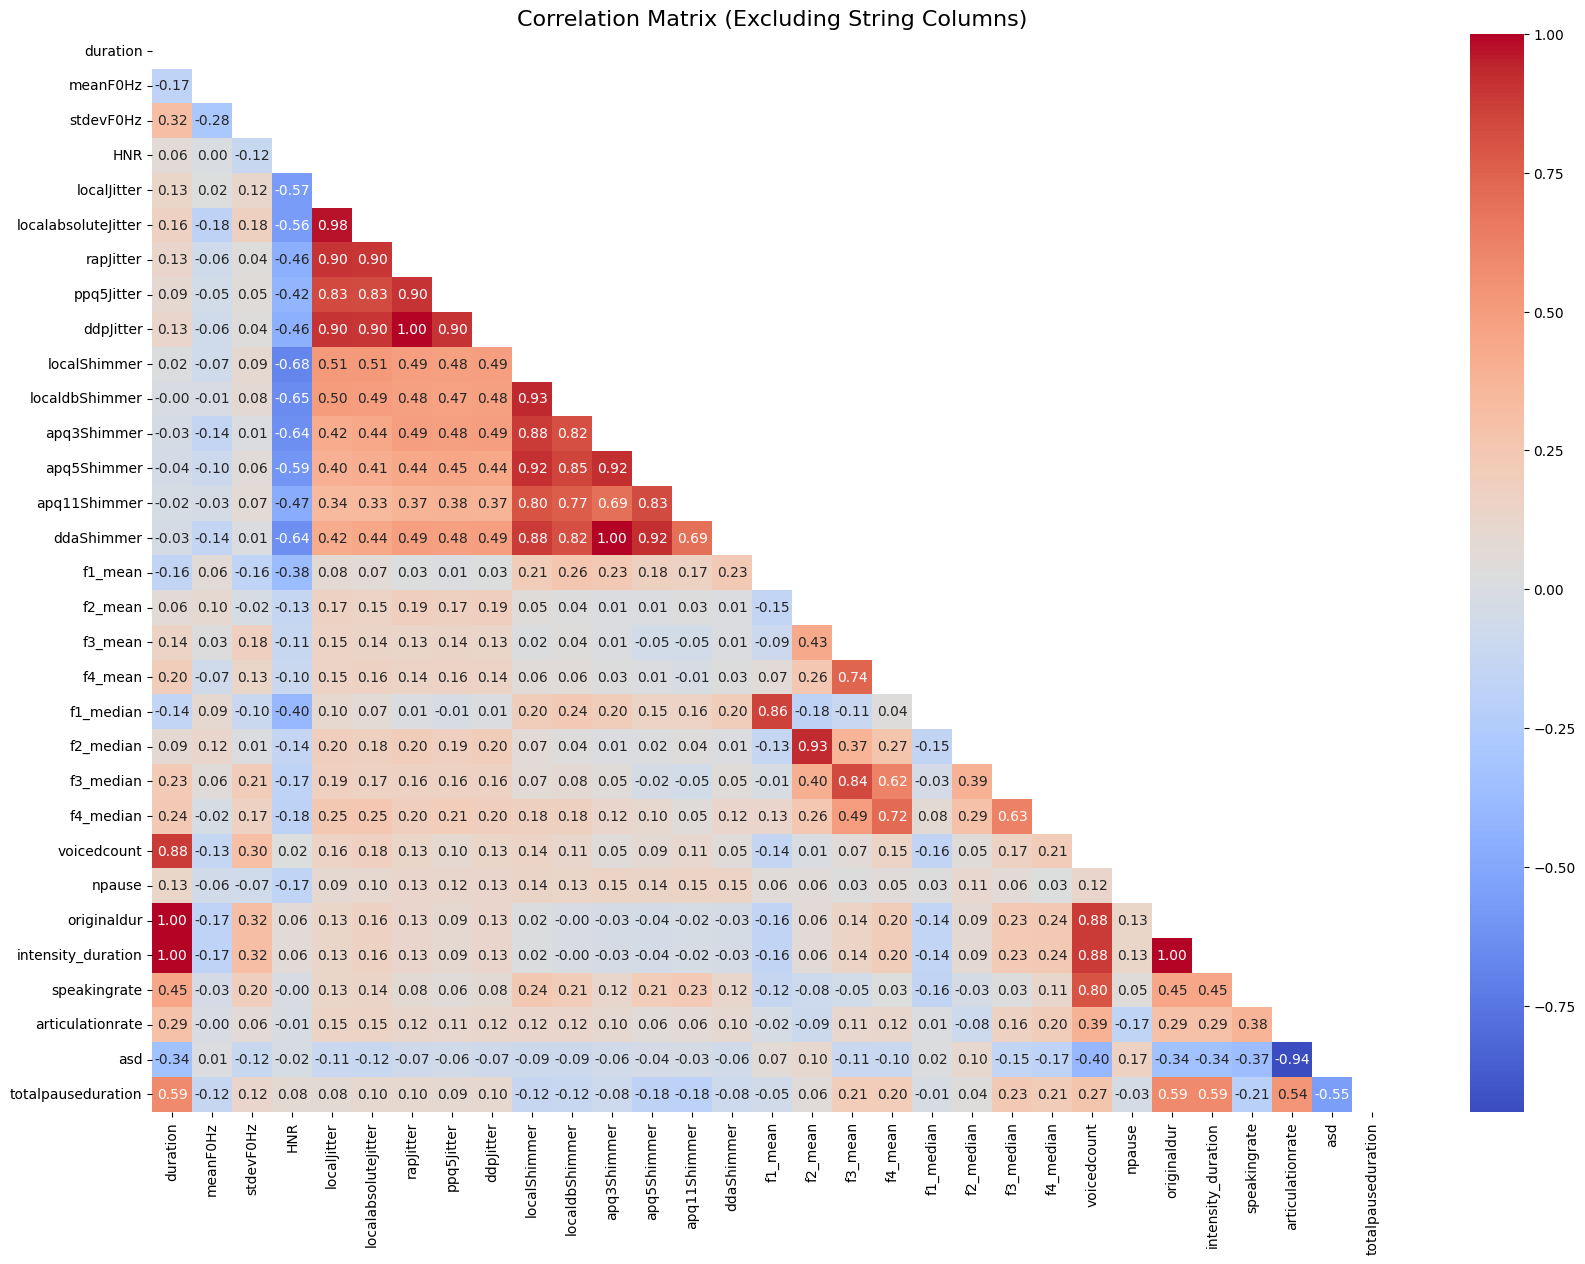

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cols_to_drop = ['labels', 'voiceID', 'real_or_fake']
df_numeric = df.drop(cols_to_drop, axis=1)

# Compute the correlation matrix
corr_matrix = df_numeric.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 14))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix (Excluding String Columns)', fontsize=16)
plt.show()

rapJitter, ppq5Jitter, and ddpJitter :
These features all measure variations in pitch but over slightly different intervals. 

localdbShimmer, apq3Shimmer, apq5Shimmer, and apq11Shimmer:
These shimmer features all measure variations in amplitude over different intervals, leading to high correlations due to their related nature.


localJitter: Measures short-term variation in the pitch period, representing small, quick changes in pitch.
localShimmer: Measures short-term variation in amplitude, representing small, quick changes in loudness.
ddaShimmer: Measures the average absolute difference between consecutive differences in amplitude, capturing average changes in loudness differences.

In [75]:
columns_to_drop = ['labels', 'voiceID', 'real_or_fake', 'rapJitter','ppq5Jitter', 'ddpJitter', 
                   'localabsoluteJitter', 'localdbShimmer','apq3Shimmer', 'apq5Shimmer','apq11Shimmer', 
                   'f1_median', 'f2_median', 'f3_median', 'f4_median', 'originaldur', 'duration', 'voicedcount']

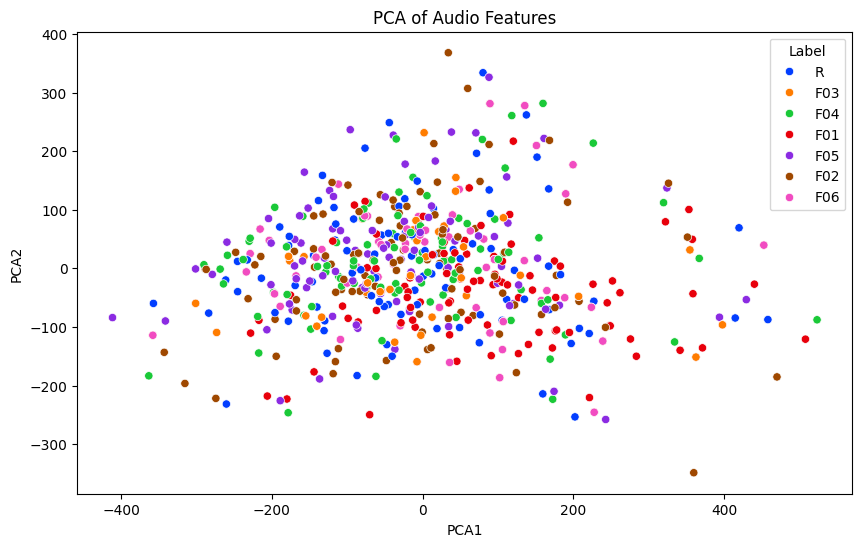

In [76]:
# Standardize the features
scaler = StandardScaler()
# scaled_features = scaler.fit_transform(df.drop(columns=['labels', 'voiceID', 'real_or_fake', 'voiceID', 'audio_data_list']))
scaled_features = df.drop(columns= columns_to_drop, axis =1)
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Label'] = df['real_or_fake']  # Include actual labels

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Label', palette='bright')
plt.title('PCA of Audio Features')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

### Modeling with Voice Quality features

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

columns_to_drop = ['voiceID', 'real_or_fake', 'rapJitter','ppq5Jitter', 'ddpJitter', 
                   'localabsoluteJitter', 'localdbShimmer','apq3Shimmer', 'apq5Shimmer','apq11Shimmer', 
                   'f1_median', 'f2_median', 'f3_median', 'f4_median', 'originaldur', 'duration', 'voicedcount']

df_new = df.drop(columns=columns_to_drop)

fake_version  = ['F01', 'F02', 'F03', 'F04', 'F05', 'F06']

for f in fake_version:
    df_new = df[df['real_or_fake'].isin([f, 'R'])]
    df_new = df_new.drop(columns= columns_to_drop )

    X = df_new.drop(columns=['labels'])
    y = df_new['labels']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print('Fake version:', f)
    print(f'Accuracy: {accuracy}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)
    print('---------------------')

df_new = df.drop(columns=columns_to_drop)

X = df_new.drop(columns=['labels'])
y = df_new['labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Overall")
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print('---------------------')

Fake version: F01
Accuracy: 0.7894736842105263
Confusion Matrix:
[[14  4]
 [ 4 16]]
Classification Report:
              precision    recall  f1-score   support

        Fake       0.78      0.78      0.78        18
        Real       0.80      0.80      0.80        20

    accuracy                           0.79        38
   macro avg       0.79      0.79      0.79        38
weighted avg       0.79      0.79      0.79        38

---------------------
Fake version: F02
Accuracy: 0.5789473684210527
Confusion Matrix:
[[10  8]
 [ 8 12]]
Classification Report:
              precision    recall  f1-score   support

        Fake       0.56      0.56      0.56        18
        Real       0.60      0.60      0.60        20

    accuracy                           0.58        38
   macro avg       0.58      0.58      0.58        38
weighted avg       0.58      0.58      0.58        38

---------------------
Fake version: F03
Accuracy: 0.6052631578947368
Confusion Matrix:
[[13  7]
 [ 8 10]]
Clas

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

### Voice Quality features are able to predict F04 vs Real audios with good accuracy and recall.